In [1]:
import symforce
symforce.set_epsilon_to_symbol()

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import vo, vio
# pose_metrics requires evo (see top of pose_metrics.py for install instructions)
import pose_metrics
import utils

# Note: this notebook requires pandas in addition to all of Prof. Bretl's dependencies
import pandas as pd

### Provide settings

In [2]:
# When matching (max threshold for ratio test)
matching_threshold = 0.1 # I recommend 0.1 for KITTI and 0.5 for EuRoC

# When deciding if triangulated points are invalid
max_reprojection_err = 0.75

# Temporary folder for evo metrics
temporary_folder = Path('./temp')
temporary_folder.mkdir(parents=True, exist_ok=True)

### Read data

In [3]:
# RUN THIS CELL FOR MAV

# MAV video folder
mav_video_folder = Path('./data/mav0')

# Read MAV data
dataset_info = utils.read_data_mav(mav_video_folder)
print("Read dataset with keys: {}".format(sorted(list(dataset_info.keys()))))

# Extract relevant data
cam0_K = dataset_info['cam0_K']
cam0_distortion = dataset_info['cam0_distortion']
visual_inertial_data = dataset_info['visual_inertial_data']

FileNotFoundError: [Errno 2] No such file or directory: 'data/mav0/cam0/sensor.yaml'

In [4]:
# RUN THIS CELL FOR KITTI
kitti_base_path = '/home/jlee/Downloads'
kitti_date = '2011_09_26'
kitti_drive = '0022'

# Read KITTI data
dataset_info = utils.read_data_kitti('/home/jlee/Downloads', '2011_09_26', '0022')

# Extract relevant data
cam0_K = dataset_info['cam0_K']
cam0_distortion = dataset_info['cam0_distortion']
visual_inertial_data = dataset_info['visual_inertial_data']

### Create random generator

In [5]:
rng = utils.create_rng(None)

seeding RNG with 1891790306


### Create image keypoint feature extractor

In [6]:
feature_extractor = cv2.SIFT_create() # could also do ORB_create() for ORB features

### Two view reconstruction

Get initial solution

In [7]:
chosen_index = 0
advance = 5

# Get first index closest to chosen index
first_frame_idx = utils.get_index_of_next_image(visual_inertial_data, chosen_index)
# Get second index
second_frame_idx = utils.get_index_of_next_image(visual_inertial_data, first_frame_idx+advance)

# Create two views
views = [
    vo.create_view_data(utils.read_image(visual_inertial_data[first_frame_idx]['image_file']),
                        first_frame_idx, feature_extractor, cam0_K, cam0_distortion),
    vo.create_view_data(utils.read_image(visual_inertial_data[second_frame_idx]['image_file']),
                        second_frame_idx, feature_extractor, cam0_K, cam0_distortion)
]

# Perform two-view reconstruction
tracks = vo.vo_2view(views, matching_threshold, cam0_K, rng, use_opencv=False)

found 70 good matches
found 70 inliers



REPROJECTION ERRORS
 Image  0 (   70 points) : (mean, std, max, min) = (  0.05,   0.10,   0.82,   0.00)
 Image (raw reprojection)  0 (   70 points) : (mean, std, max, min) = (  0.05,   0.10,   0.82,   0.00)
 Image  1 (   70 points) : (mean, std, max, min) = (  0.05,   0.10,   0.80,   0.00)
 Image (raw reprojection)  1 (   70 points) : (mean, std, max, min) = (  0.05,   0.10,   0.80,   0.00)


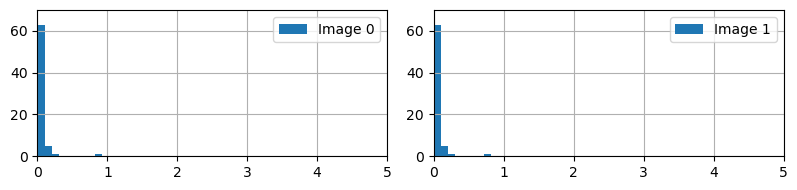

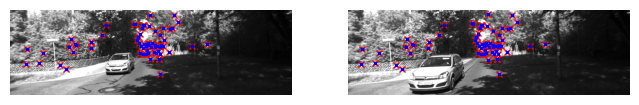

In [8]:
vo.show_reproj_results(views, tracks, cam0_K, cam0_distortion, print_raw_reproj=True, show_reproj_histogram=True)
vo.visualize_predictions(views, tracks, cam0_K, cam0_distortion)

In [9]:
def imu_collate(data):
    w_x = np.stack([d['w_x'] for d in data])
    w_y = np.stack([d['w_y'] for d in data])
    w_z = np.stack([d['w_z'] for d in data])

    a_x = np.stack([d['a_x'] for d in data])
    a_y = np.stack([d['a_y'] for d in data])
    a_z = np.stack([d['a_z'] for d in data])

    acc_meas = np.vstack([a_x, a_y, a_z]).T
    gyr_meas = np.vstack([w_x, w_y, w_z]).T
    
    return acc_meas, gyr_meas

acc_meas, gyr_meas = imu_collate(dataset_info['visual_inertial_data'][first_frame_idx:second_frame_idx])

Get post-optimization solution

In [10]:
views, tracks = vio.vio_nonlinear_optimize(views, tracks, acc_meas, gyr_meas, cam0_K, max_reprojection_err)

[2024-04-29 18:36:40.325] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 5003095969.310/0.000/407442624.000, rel reduction: 0.91856
[2024-04-29 18:36:40.335] [info] LM<sym::Optimize> [iter    1] lambda: 1.000e-01, error prev/linear/new: 407442624.840/0.000/692333.625, rel reduction: 0.99830
[2024-04-29 18:36:40.345] [info] LM<sym::Optimize> [iter    2] lambda: 1.000e-02, error prev/linear/new: 692333.636/0.000/91.439, rel reduction: 0.99987
[2024-04-29 18:36:40.354] [info] LM<sym::Optimize> [iter    3] lambda: 1.000e-03, error prev/linear/new: 91.439/0.000/33.371, rel reduction: 0.63505
[2024-04-29 18:36:40.364] [info] LM<sym::Optimize> [iter    4] lambda: 1.000e-04, error prev/linear/new: 33.371/0.000/31.320, rel reduction: 0.06146
[2024-04-29 18:36:40.374] [info] LM<sym::Optimize> [iter    5] lambda: 1.000e-05, error prev/linear/new: 31.320/0.000/22.219, rel reduction: 0.29058
[2024-04-29 18:36:40.383] [info] LM<sym::Optimize> [iter    6] lambda: 1.000

Evaluate change in position between frames

In [11]:
from scipy.spatial.transform import Rotation as R

R_inB0_ofW_gt = R.from_quat([
    dataset_info['visual_inertial_data'][first_frame_idx]['groundtruth']['q_x'],
    dataset_info['visual_inertial_data'][first_frame_idx]['groundtruth']['q_y'],
    dataset_info['visual_inertial_data'][first_frame_idx]['groundtruth']['q_z'],
    dataset_info['visual_inertial_data'][first_frame_idx]['groundtruth']['q_w'],
    ]).as_matrix()

p_inB0_ofW_gt = np.array([
    dataset_info['visual_inertial_data'][first_frame_idx]['groundtruth']['p_x'],
    dataset_info['visual_inertial_data'][first_frame_idx]['groundtruth']['p_y'],
    dataset_info['visual_inertial_data'][first_frame_idx]['groundtruth']['p_z'],
    ])

R_inB1_ofW_gt = R.from_quat([
    dataset_info['visual_inertial_data'][second_frame_idx]['groundtruth']['q_x'],
    dataset_info['visual_inertial_data'][second_frame_idx]['groundtruth']['q_y'],
    dataset_info['visual_inertial_data'][second_frame_idx]['groundtruth']['q_z'],
    dataset_info['visual_inertial_data'][second_frame_idx]['groundtruth']['q_w'],
    ]).as_matrix()

p_inB1_ofW_gt = np.array([
    dataset_info['visual_inertial_data'][second_frame_idx]['groundtruth']['p_x'],
    dataset_info['visual_inertial_data'][second_frame_idx]['groundtruth']['p_y'],
    dataset_info['visual_inertial_data'][second_frame_idx]['groundtruth']['p_z'],
    ])

p_inB1_ofB0_gt = - R_inB1_ofW_gt @ R_inB0_ofW_gt.T @ p_inB0_ofW_gt + p_inB1_ofW_gt
print(p_inB1_ofB0_gt)

[ 0.07641386  0.26302993 -0.15351105]


In [12]:
R_inB0_ofA_sf = views[0]['R_inB_ofA']
p_inB0_ofA_sf = views[0]['p_inB_ofA']
R_inB1_ofA_sf = views[1]['R_inB_ofA']
p_inB1_ofA_sf = views[1]['p_inB_ofA']

p_inB1_ofB0_sf = - R_inB1_ofA_sf @ R_inB0_ofA_sf.T @ p_inB0_ofA_sf + p_inB1_ofA_sf
print(p_inB1_ofB0_sf)

[-0.01859577 -0.02450853 -0.6012822 ]



REPROJECTION ERRORS
 Image  0 (   66 points) : (mean, std, max, min) = (  0.04,   0.04,   0.21,   0.00)
 Image (raw reprojection)  0 (   66 points) : (mean, std, max, min) = (  0.04,   0.04,   0.21,   0.00)
 Image  1 (   66 points) : (mean, std, max, min) = (  0.04,   0.04,   0.21,   0.00)
 Image (raw reprojection)  1 (   66 points) : (mean, std, max, min) = (  0.04,   0.04,   0.21,   0.00)


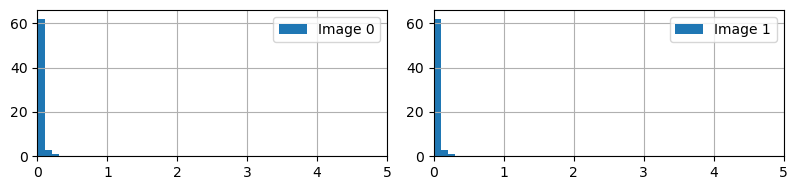

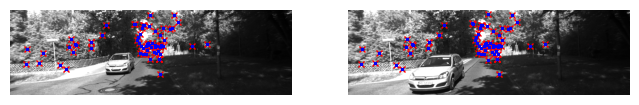

In [13]:
vo.show_reproj_results(views, tracks, cam0_K, cam0_distortion, print_raw_reproj=True, show_reproj_histogram=True)
vo.visualize_predictions(views, tracks, cam0_K, cam0_distortion)

### Compute APE - example
Note, because we only have 2 views we don't have sufficient data to actually do an alignment.

In [ ]:
ape_results = pose_metrics.compute_ape(
    pose_metrics.create_tum_data_from_views(times=[visual_inertial_data[view['frame_id']]['time'] for view in views], views=views),
    pose_metrics.create_tum_data_from_groundtruth([visual_inertial_data[view['frame_id']] for view in views]),
    temporary_folder / Path('traj1.txt'),
    temporary_folder / Path('traj2.txt'),
    temporary_folder / Path('results.zip'),
    temporary_folder / Path('results/'),
    align='none', verbose=False, print_results=True,
)

### Compute pose error (with my alignment) example
Basically, we do a coordinate transform so both trajectories start at 0 pose and identity rotation. Then we calculate the error for each time-step. In our case, we probably should just care about the final error elements (which specifies errors between first and last frame).

In [ ]:
pose_results = pose_metrics.compute_pose_error(
    pose_metrics.create_tum_data_from_views(times=[visual_inertial_data[view['frame_id']]['time'] for view in views], views=views),
    pose_metrics.create_tum_data_from_groundtruth([visual_inertial_data[view['frame_id']] for view in views]),
    align='posescale', print_results=True,
)